In [1]:
import sys

sys.path.append("../")

In [2]:
from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# 1. Load data, prep & train test split

In [3]:
df = pd.read_csv("../datasets/fin_churn.csv" )
df = df.rename(columns=dict(zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.exited.value_counts()/df.shape[0]*100

exited
0    79.63
1    20.37
Name: count, dtype: float64

In [5]:
70.63/20.37

3.467353951890034

In [6]:
20.37/70.63

0.28840436075322107

In [7]:
df.isna().any()

row_number          False
customer_id         False
surname             False
credit_score        False
geography           False
gender              False
age                 False
tenure              False
balance             False
num_of_products     False
has_cr_card         False
is_active_member    False
estimated_salary    False
exited              False
dtype: bool

In [8]:
y = "exited"

# some generic cleaning

COLUMNS_TO_DROP = ["customer_id", "surname"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [13]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [6,8,10,12],
    'under__sampling_strategy': [0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.5, 0.7, 1]
}

model = LogisticRegression()

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/imblearn/pipeline.py", line 293, in fit
    Xt

Best score: 0.772149935953617
Best parameters: {'logistic__C': 1, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 12, 'under__sampling_strategy': 0.5}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['row_number', 'credit_score',
                                                   'age', 'tenure', 'balance',
                                                   'num_of_products',
                                                   'has_cr_card',
                                                   'is_active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['geography', 'gender'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=12)),
                ('logistic', LogisticRegression(C=1))])

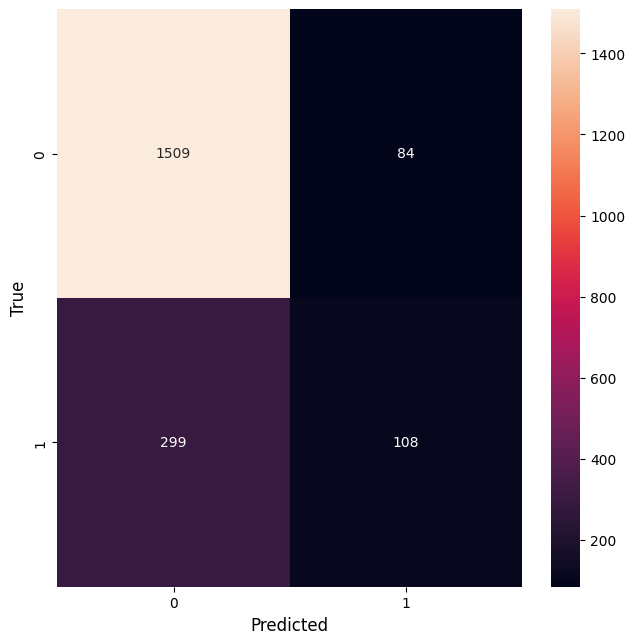

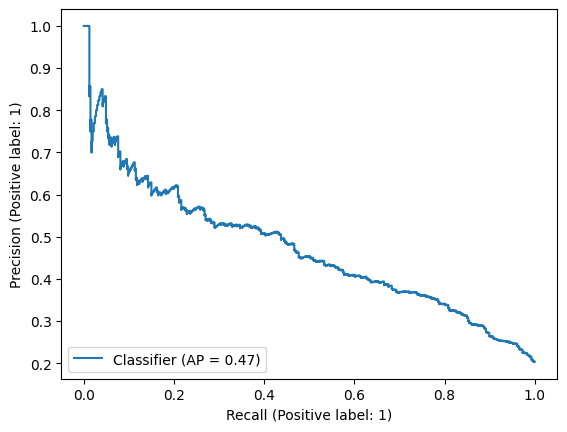

In [15]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y)